## Kohonen Self-Organizing Map (SOM) for image feature vectors

This notebook describes simple way to get image feature vectors using Imagenet pre-trained ResNet50 model. The images are from Oxford University 17 category flower photo dataset that contains total 1360 flower photos.
The dataset is available from http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html

Processing the photos with ResNet50 takes few minutes on a CPU-only device, so GPU acceleration is not necessary to run this code. 

The SOM performs unsupervised clustering of the feature vectors. The photo category labels are used at the end of this notebook to visually check the clustering accuracy. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib, random, time, sys, math, cv2, glob 
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.decomposition import PCA

from som import SOM, plot_data_on_map

## Load pre-trained ResNet50 model and use it to generate image feature vectors
This is pretty standard process flow: get image paths, load images, process the images by ResNet model and then use PCA to reduce the vector dimensionality. The ResNet feature vectors have 2048 dimensions, which is often unnecessarily large and just causes computing load without much benefits. Something like 300 dimensions is often enough. 

In [ ]:
model = ResNet50(weights='imagenet', include_top=False)

def get_img_feature_vector(model, image_path): 
    img_target_size = (224, 224)
    img = cv2.imread(image_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       
    img = cv2.resize(img, dsize=img_target_size)
    img = preprocess_input(img.copy().astype(np.float32))
    vect = model.predict(np.expand_dims(img, axis=0), verbose=0)[0, 0, 0]
    return vect

# Get all image paths from the images folder. 
img_paths = glob.glob("images/*.jpg", recursive=False)
img_paths.sort()
n_images = len(img_paths)

# Initialize array for the feature vectors
img_vectors = np.zeros((n_images, 2048), dtype=np.float32)
   
# Progress monitoring, since the processing may take some time
sys.stdout.write('Processing images')
print_count = 0 
n_per_report_step = n_images // 20

# Process each image
for idx in range(n_images):
    path = img_paths[idx]
    vect = get_img_feature_vector(model, path)
    img_vectors[idx] = vect

    if idx % n_per_report_step == 0: 
        print_count += 1
        sys.stdout.write(f'\rProcessing images ' +' [' + '=' * (print_count) + '>' + '.' * (20 - print_count) + ']')

# Save the feature vectors
np.save('img_vectors.npy', img_vectors)
print('Done')

In [ ]:
# Load pre-processed vectors (if the above steps were run in earlier session)
img_vectors = np.load('img_vectors.npy')
n_images = img_vectors.shape[0]

In [ ]:
# Run PCA to reduce hte feature vector dimensionality
pca = PCA(n_components=300, whiten=True, svd_solver='full')
pca.fit(img_vectors.copy())
dataset = pca.transform(img_vectors.copy())

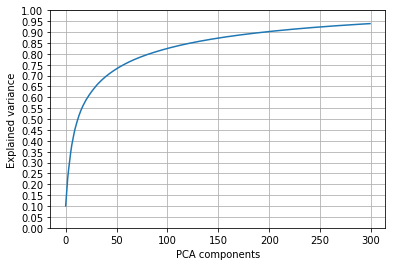

In [48]:
# Plot the explained variance vs. PCA components curve
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.linspace(0, 1, 21))
plt.grid()
plt.ylim(0, 1)
plt.xlabel('PCA components')
plt.ylabel('Explained variance')
plt.show()

## Create Self Organizing Map 

Create SOM instance with 40 x 20 nodes and 300 channels (vector length). 

In [33]:
# Create the SOM instance.
som = SOM()
som.create(40, 20, 300)

# Fit the map to the dataset using total 20 optimization rounds.
# Random_samplie is 1, i.e. all samples are used to train the map at each iteration. 
# Learning rate 1 seems to work well with this dataset. 
som.fit(dataset, random_sampling=1, lr=1, n_iter=20)
som.save('map_40x20x300.npy')

Processing SOM iteration 1/20 [====================>] Average distance = 17.03440
Processing SOM iteration 2/20 [====================>] Average distance = 16.99686
Processing SOM iteration 3/20 [====================>] Average distance = 16.97712
Processing SOM iteration 4/20 [====================>] Average distance = 16.91834
Processing SOM iteration 5/20 [====================>] Average distance = 16.90568
Processing SOM iteration 6/20 [====================>] Average distance = 16.82111
Processing SOM iteration 7/20 [====================>] Average distance = 16.76210
Processing SOM iteration 8/20 [====================>] Average distance = 16.68006
Processing SOM iteration 9/20 [====================>] Average distance = 16.61287
Processing SOM iteration 10/20 [====================>] Average distance = 16.48315
Processing SOM iteration 11/20 [====================>] Average distance = 16.41359
Processing SOM iteration 12/20 [====================>] Average distance = 16.28189
Processing SO

True

## Find data vector locations on the map
The best matching map node locations and euclidean distances to those will be returned by the find_maching_nodes method.

In [34]:
data_locations, vect_distances = som.find_maching_nodes(dataset)

Finding mathing nodes [====================>] Done


## Get the map U-matrix
U-matrix is 2D array where each cell represents the average map vector distance (euclidean) to the neighbor cells. 
It can be used to illustrate map clusters, since typically at cluster center the distances are small (colors are dark). Distances get bigger (color is lighter) at cluster borders. 

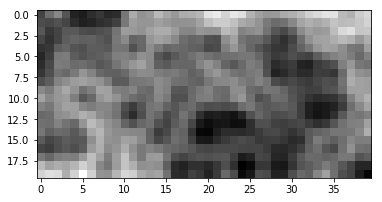

In [36]:
umatrix = som.get_umatrix()
plt.imshow(umatrix, cmap='gray')

## Plot the data vectors on the trained map
This plots the U-matrix and then overlays the data vectors as dots on top of it. The vector colors are defined according to the class labels, which are available in the VGG flower dataset site. 

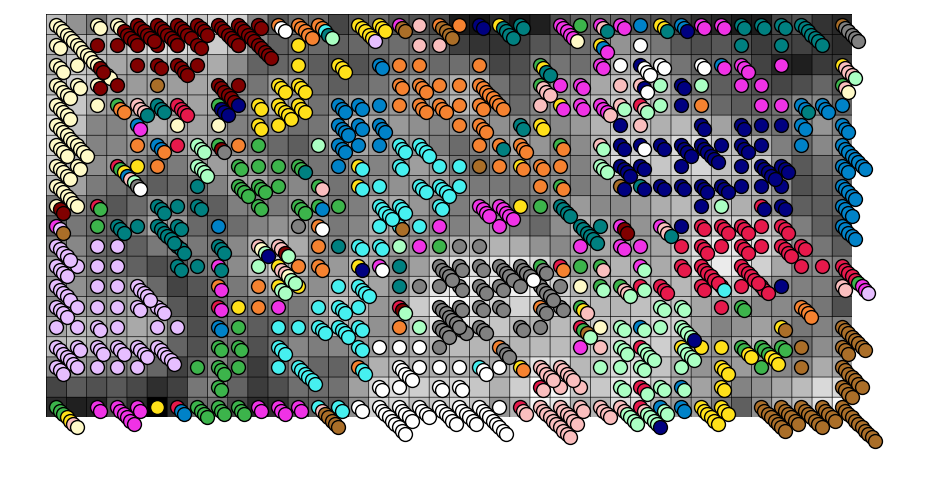

Image saved to SOM_mapping_1536517976.png


In [51]:
# Load labels for visualization purposes. There have been pre-processed from the flower dataset matlab files. 
labels = np.load('flower_labels.npy')

# Define color palette. The values are selected so that those are easily distinguishable from each other. 
palette = np.array([[0.90196078, 0.09803922, 0.29411765],
                   [0.23529412, 0.70588235, 0.29411765],
                   [1.        , 0.88235294, 0.09803922],
                   [0.        , 0.50980392, 0.78431373],
                   [0.96078431, 0.50980392, 0.18823529],
                   [0.2745098 , 0.94117647, 0.94117647],
                   [0.94117647, 0.19607843, 0.90196078],
                   [0.98039216, 0.74509804, 0.74509804],
                   [0.        , 0.50196078, 0.50196078],
                   [0.90196078, 0.74509804, 1.        ],
                   [0.66666667, 0.43137255, 0.15686275],
                   [1.        , 0.98039216, 0.78431373],
                   [0.50196078, 0.        , 0.        ],
                   [0.66666667, 1.        , 0.76470588],
                   [0.        , 0.        , 0.50196078],
                   [0.50196078, 0.50196078, 0.50196078],
                   [1.        , 1.        , 1.        ]])


# Define color for each image vector index. 
colors = np.zeros((n_images, 3))
for i in range(n_images):
    colors[i] = palette[labels[i] - 1]
    
# Plot the vector locations on the map using the colors defined above
plot_data_on_map(umatrix, data_locations, data_colors=colors, 
                 node_width=30, data_marker_size=100)     

From the above plot it can be seen that the SOM did manage to correctly clusterize about half of the classes, which shows up as clusters of same color circles. Rest of the vectors are more difficult for unsupervised clustering like this and end up being mixed with vectors from other classes.